Commercial banks receive _a lot_ of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report, for example. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!). Luckily, this task can be automated with the power of machine learning and pretty much every commercial bank does so nowadays. In this notebook, we will build an automatic credit card approval predictor using machine learning techniques, just like real banks do.

![Credit card being held in hand](credit_card.jpg)

You have been provided with a small subset of the credit card applications a bank receives. The dataset has been loaded as a Pandas DataFrame for you. You will start from there. 

In [79]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

In [82]:
# Load dataset
cc_apps = pd.read_csv("cc_approvals.data", header=None)

# Drop the features 11 and 13
cc_apps = cc_apps.drop([11, 13], axis=1)

# Split into train and test sets
cc_apps_train, cc_apps_test = train_test_split(cc_apps, test_size=0.33, random_state=42)

# Replace the '?'s with NaN in the train and test sets
cc_apps_train_nans_replaced = cc_apps_train.replace("?", np.NaN)
cc_apps_test_nans_replaced = cc_apps_test.replace("?", np.NaN)

# Impute the missing values with mean imputation
cc_apps_train_imputed = cc_apps_train_nans_replaced.fillna(cc_apps_train_nans_replaced.mean())
cc_apps_test_imputed = cc_apps_test_nans_replaced.fillna(cc_apps_train_nans_replaced.mean())

# Iterate over each column of cc_apps_train_imputed
for col in cc_apps_train_imputed.columns:
    # Check if the column is of object type
    if cc_apps_train_imputed[col].dtypes == "object":
        # Impute with the most frequent value
        cc_apps_train_imputed = cc_apps_train_imputed.fillna(
            cc_apps_train_imputed[col].value_counts().index[0]
        )
        cc_apps_test_imputed = cc_apps_test_imputed.fillna(
            cc_apps_train_imputed[col].value_counts().index[0]
        )

# Convert the categorical features in the train and test sets independently
cc_apps_train_cat_encoding = pd.get_dummies(cc_apps_train_imputed)
cc_apps_test_cat_encoding = pd.get_dummies(cc_apps_test_imputed)

# Reindex the columns of the test set aligning with the train set
cc_apps_test_cat_encoding = cc_apps_test_cat_encoding.reindex(
    columns=cc_apps_train_cat_encoding.columns, fill_value=0
)

# Segregate features and labels into separate variables
X_train, y_train = (
    cc_apps_train_cat_encoding.iloc[:, :-1].values,
    cc_apps_train_cat_encoding.iloc[:, [-1]].values,
)
X_test, y_test = (
    cc_apps_test_cat_encoding.iloc[:, :-1].values,
    cc_apps_test_cat_encoding.iloc[:, [-1]].values,
)

# Instantiate MinMaxScaler and use it to rescale X_train and X_test
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.transform(X_test)

# Instantiate a LogisticRegression classifier with default parameter values
logreg = LogisticRegression()

# Fit logreg to the train set
logreg.fit(rescaledX_train, y_train)

# Use logreg to predict instances from the test set and store it
y_pred = logreg.predict(rescaledX_test)

# Print the confusion matrix of the logreg model
print(confusion_matrix(y_test, y_pred))

# Define the grid of values for tol and max_iter
tol = [0.01, 0.001, 0.0001]
max_iter = [100, 150, 200]

# Create a dictionary where tol and max_iter are keys and the lists of their values are the corresponding values
param_grid = dict(tol=tol, max_iter=max_iter)

# Instantiate GridSearchCV with the required parameters
grid_model = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5)

# Fit grid_model to the data
grid_model_result = grid_model.fit(rescaledX_train, y_train)

# Summarize results
best_score, best_params = grid_model_result.best_score_, grid_model_result.best_params_
print("Best: %f using %s" % (best_score, best_params))

# Extract the best model and evaluate it on the test set
best_model = grid_model_result.best_estimator_
print(
    "Accuracy of logistic regression classifier: ",
    best_model.score(rescaledX_test, y_test),
)

# Confusion matrix


[[103   0]
 [  0 125]]
Best: 1.000000 using {'max_iter': 100, 'tol': 0.01}
Accuracy of logistic regression classifier:  1.0


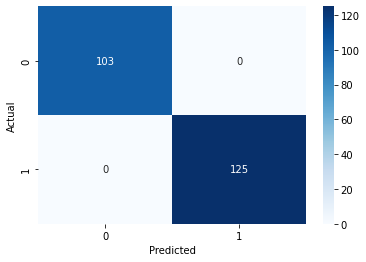

In [84]:
#  Model training and evaluation
log_reg = LogisticRegression(C=100.0, penalty='l1', solver='liblinear')
log_reg.fit(X_train,y_train)
y_pred = log_reg.predict(X_test)
accuracy = log_reg.score(X_test, y_test)
# print(f"Accuracy: {accuracy:.2f}")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# print(classification_report(y_test, y_pred))